# Análise de Exportações de Vinho Brasileiro (2009-2023)

## Objetivo
Este notebook tem como objetivo analisar os dados de exportação de vinhos brasileiros, abrangendo o período de 2009 a 2023. A análise focará em identificar os principais países importadores, as tendências de volume (quantidade) e valor ao longo do tempo, e investigar o impacto de eventos globais, como a pandemia de COVID-19, no comportamento das exportações.

**Fonte dos Dados:** `tabela.csv` (dados de exportação por país).

## 1. Configuração do Ambiente e Carregamento dos Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração para exibir todas as colunas do dataframe
pd.set_option('display.max_columns', None)

In [2]:
# Carregando o arquivo CSV para um DataFrame do Pandas
df_raw = pd.read_csv('tabela.csv')

## 2. Limpeza e Pré-processamento dos Dados

A estrutura original dos dados está em formato *wide*, com colunas separadas para quantidade e valor para cada ano. Para facilitar a análise e a visualização, os dados serão remodelados para o formato *long*, onde teremos colunas para 'Ano', 'Metrica' (Quantidade ou Valor) e 'Valor da Métrica'.

In [3]:
# Renomeando a primeira coluna para 'Pais' para facilitar a identificação
df_raw = df_raw.rename(columns={'País 2008': 'Pais'}) # O ano 2008 não tem dados, apenas nomes de países.

# Separando a linha de 'Total' para uma análise agregada posterior
df_total = df_raw[df_raw['Pais'] == 'Total'].copy()
df_paises = df_raw[df_raw['Pais'] != 'Total'].copy()

# Função para remodelar (melt) o dataframe para o formato longo
def melt_data(df, value_prefix, value_name):
    id_vars = ['Pais']
    value_vars = [col for col in df.columns if col.startswith(value_prefix)]

    df_melted = df.melt(
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='Ano',
        value_name=value_name
    )
    # Extrai o ano da string da coluna e converte para numérico
    df_melted['Ano'] = df_melted['Ano'].str.extract('(\\d{4})').astype(int)
    return df_melted

# Processando os dados de Quantidade e Valor
df_qtd = melt_data(df_paises, 'Qtd', 'Quantidade')
df_valor = melt_data(df_paises, 'Valor', 'Valor_USD')

# Unindo os dois dataframes em um único dataframe mestre
df_final = pd.merge(df_valor, df_qtd, on=['Pais', 'Ano'])

print("Visualização do DataFrame final processado:")
df_final.head()

Visualização do DataFrame final processado:


,Pais,Ano,Valor_USD,Quantidade
0,Afeganistão,2009,0,0
1,África do Sul,2009,0,0
2,"Alemanha, República Democrática",2009,393482,225086
3,Angola,2009,84235,54786
4,Anguilla,2009,0,0


## 3. Análise Exploratória de Dados (EDA)

### 3.1. Evolução Total das Exportações (Valor vs. Quantidade)
Analisando a evolução do valor total exportado (em USD) e da quantidade total (em Kg).

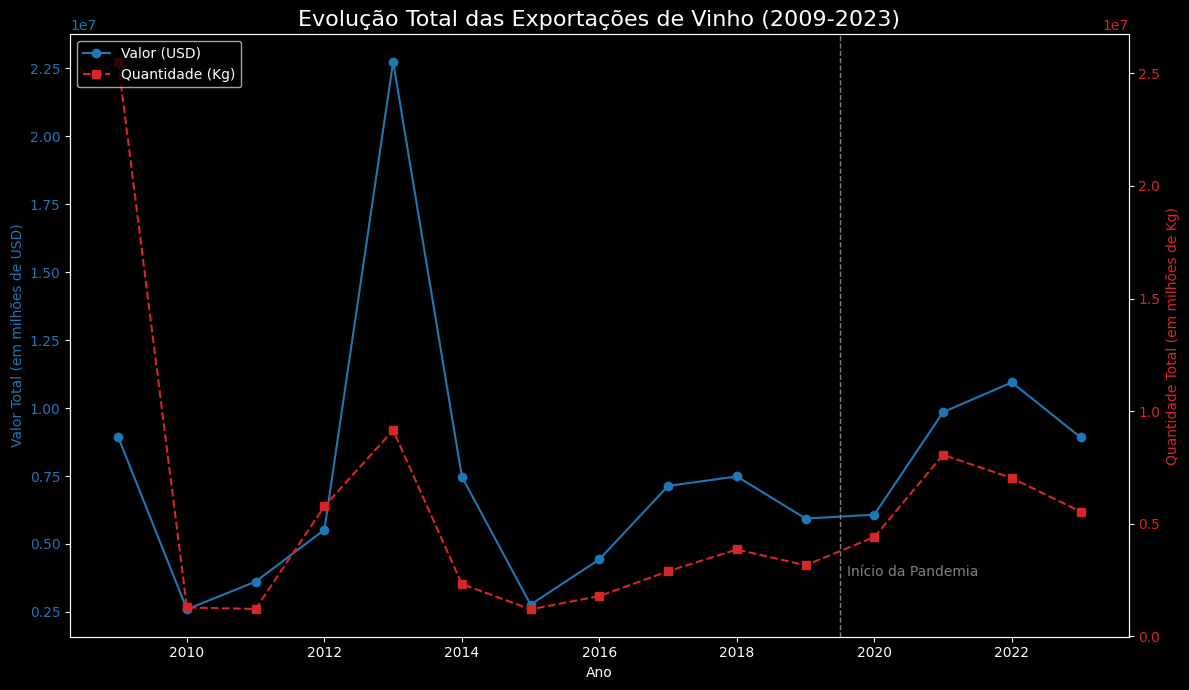

In [4]:
# Processando os dados totais
df_total_valor = melt_data(df_total, 'Valor', 'Valor_USD')
df_total_qtd = melt_data(df_total, 'Qtd', 'Quantidade')
df_total_agregado = pd.merge(df_total_valor, df_total_qtd, on='Ano')

# --- Configuração Inicial ---
# Define o tema para aproximar do 'plotly_dark'. Use 'ggplot' ou 'seaborn-v0_8-darkgrid' se preferir.
plt.style.use('dark_background')

# Cria a Figura e o primeiro eixo (ax1)
fig, ax1 = plt.subplots(figsize=(12, 7))

# Define a cor para cada eixo para facilitar a leitura
color1 = 'tab:blue'
color2 = 'tab:red'

# --- Eixo 1: Valor (USD) ---
ax1.set_xlabel('Ano')
ax1.set_ylabel('Valor Total (em milhões de USD)', color=color1)
ax1.plot(df_total_agregado['Ano'], df_total_agregado['Valor_USD'],
         color=color1, marker='o', label='Valor (USD)')
ax1.tick_params(axis='y', labelcolor=color1)

# --- Eixo 2: Quantidade (Kg) ---
# Cria um segundo eixo (ax2) que compartilha o eixo X (ax1.twinx())
ax2 = ax1.twinx()
ax2.set_ylabel('Quantidade Total (em milhões de Kg)', color=color2)
ax2.plot(df_total_agregado['Ano'], df_total_agregado['Quantidade'],
         color=color2, marker='s', linestyle='--', label='Quantidade (Kg)')
ax2.tick_params(axis='y', labelcolor=color2)

# --- Anotações e Títulos ---
# Adicionando a linha vertical da pandemia
ax1.axvline(x=2019.5, color='grey', linestyle='--', linewidth=1)
# Adicionando o texto da anotação
# (Posiciona o texto 10% acima do mínimo do eixo Y)
y_pos = ax1.get_ylim()[0] + (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.1
ax1.text(2019.5 + 0.1, y_pos, 'Início da Pandemia', color='grey', fontsize=10)

# Título do Gráfico
plt.title('Evolução Total das Exportações de Vinho (2009-2023)', fontsize=16)

# --- Legenda ---
# Criar a legenda pode ser complicado com 'twinx()'.
# Este é o método padrão para combinar as duas legendas em uma só caixa.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Ajusta o layout para evitar que os rótulos se sobreponham
fig.tight_layout()

# Mostra o gráfico
plt.show()

**Observação:** O gráfico mostra uma grande volatilidade ao longo dos anos. Há um pico notável de valor em 2013, que não é acompanhado por um pico proporcional em quantidade, sugerindo a exportação de produtos de maior valor agregado. A partir de 2020, observa-se um crescimento expressivo tanto em valor quanto em quantidade, atingindo picos em 2021 e 2022.

### 3.2. Análise dos Principais Parceiros Comerciais
Vamos identificar os 5 principais destinos das exportações de vinho brasileiro com base no valor total acumulado no período.

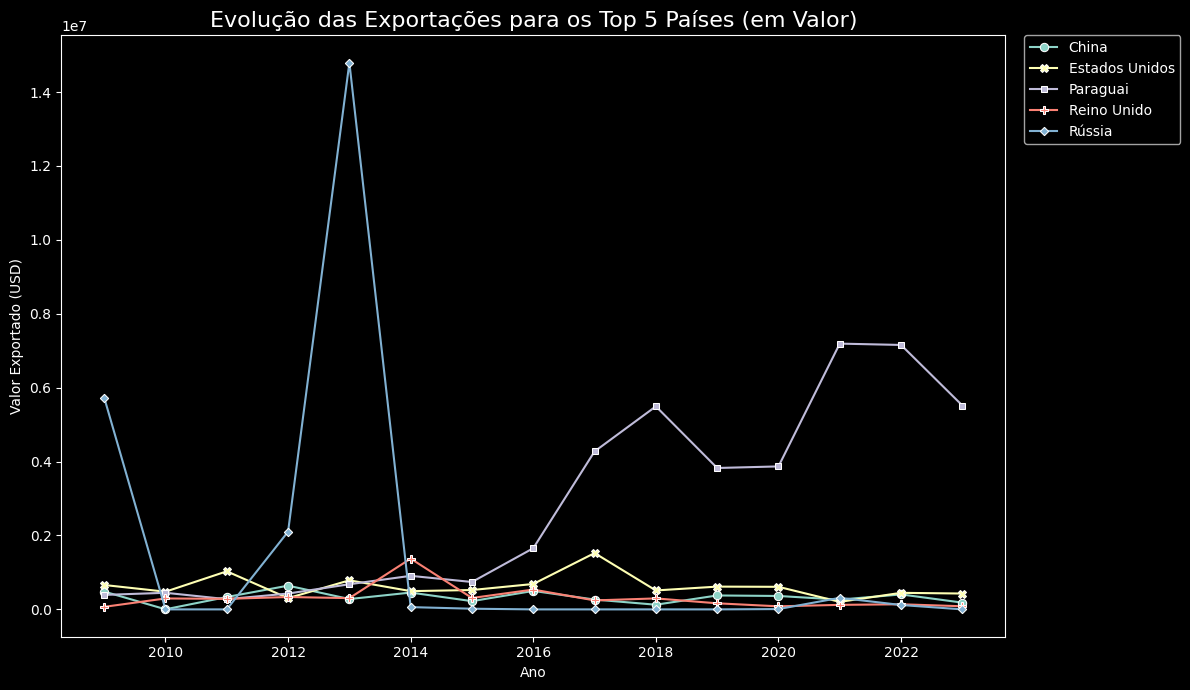

In [5]:
# Calculando o valor total por país para identificar os principais parceiros
top_5_paises = df_final.groupby('Pais')['Valor_USD'].sum().nlargest(5).index
df_top_5 = df_final[df_final['Pais'].isin(top_5_paises)]

plt.style.use('dark_background')
plt.figure(figsize=(12, 7))

ax = sns.lineplot(
    data=df_top_5,
    x='Ano',
    y='Valor_USD',
    hue='Pais',
    style='Pais',
    markers=True,
    dashes=False
)

ax.set_title('Evolução das Exportações para os Top 5 Países (em Valor)', fontsize=16)
ax.set_xlabel('Ano')
ax.set_ylabel('Valor Exportado (USD)')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()

plt.show()

**Análise:** O Paraguai se destaca como o principal importador de forma consistente. O Haiti mostra um crescimento surpreendente e expressivo a partir de 2020. Estados Unidos, China e Reino Unido aparecem como outros parceiros importantes, mas com volumes de importação mais voláteis.

### 3.3. Análise de Países Específicos

#### Paraguai: O Gigante da Vizinhança
Como principal parceiro, o Paraguai merece uma análise individualizada.

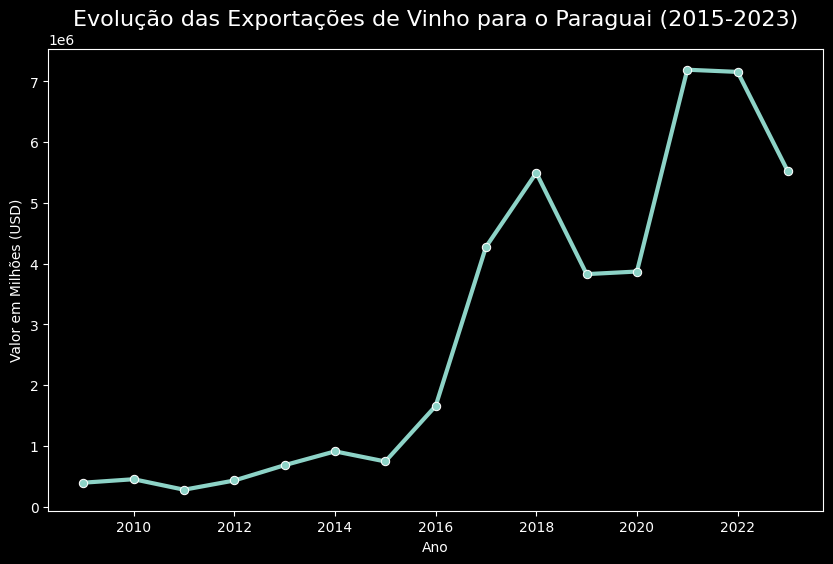

In [6]:
df_paraguai = df_final[df_final['Pais'] == 'Paraguai']

plt.style.use('dark_background')
plt.figure(figsize=(10, 6))

ax = sns.lineplot(
    data=df_paraguai,
    x='Ano',
    y='Valor_USD',
    markers=True,
    marker='o',
    linewidth=3
)

ax.set_title('Evolução das Exportações de Vinho para o Paraguai (2015-2023)', fontsize=16)
ax.set_xlabel('Ano')
ax.set_ylabel('Valor em Milhões (USD)')

plt.show()

#### Haiti: Um Mercado Emergente Pós-2019
O aumento das exportações de vinho para o Haiti após 2019 pode ser atribuído a uma combinação de fatores econômicos, sociais e comerciais que transformaram o país em um mercado emergente para vinhos importados, incluindo os brasileiros.

1.  **Crescimento da Classe Média e Mudança de Hábitos:** Observou-se um crescimento da classe média haitiana, com maior interesse por produtos de status como o vinho.
2.  **Expansão das Exportações Brasileiras:** Ações promocionais e a desvalorização cambial tornaram os vinhos brasileiros mais competitivos. Vinícolas como a Aurora ampliaram sua presença no mercado haitiano.
3.  **Influência do Turismo:** O aumento do turismo internacional no Haiti também contribuiu para a maior demanda por vinhos importados em hotéis e restaurantes.

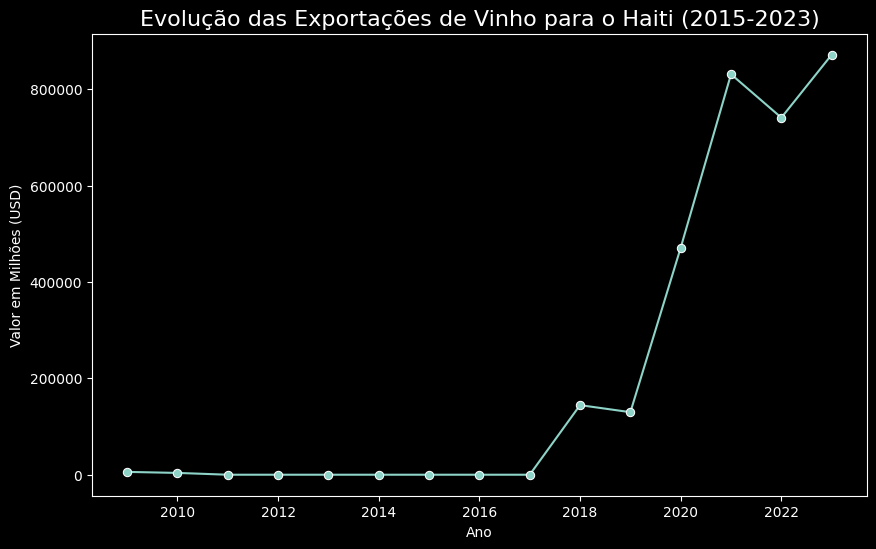

In [7]:
df_haiti = df_final[df_final['Pais'] == 'Haiti']

plt.style.use('dark_background')
plt.figure(figsize=(10, 6))

ax = sns.lineplot(
    data=df_haiti,
    x='Ano',
    y='Valor_USD',
    markers=True,
    marker='o'
)

ax.set_title('Evolução das Exportações de Vinho para o Haiti (2015-2023)', fontsize=16)
ax.set_xlabel('Ano')
ax.set_ylabel('Valor em Milhões (USD)')

plt.show()

#### Estados Unidos vs. China: Comparativo de Gigantes
Analisando a evolução das exportações para duas das maiores economias do mundo.

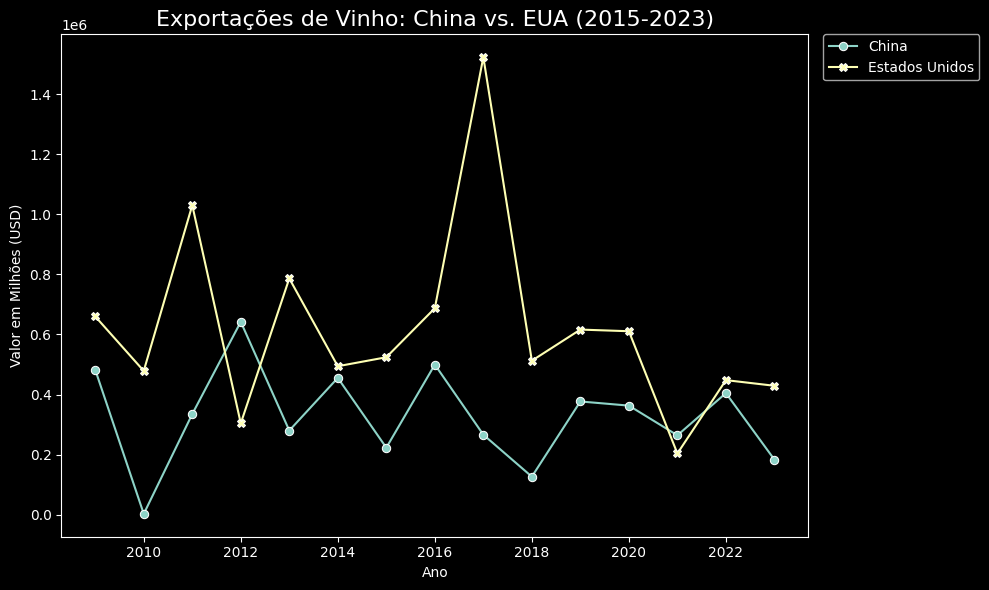

In [8]:
# Filtrando dados para EUA e China
df_eua_china = df_final[df_final['Pais'].isin(['Estados Unidos', 'China'])]

plt.style.use('dark_background')
plt.figure(figsize=(10, 6))

ax = sns.lineplot(
    data=df_eua_china,
    x='Ano',
    y='Valor_USD',
    hue='Pais',
    style='Pais',
    markers=True,
    dashes=False
)

ax.set_title('Exportações de Vinho: China vs. EUA (2015-2023)', fontsize=16)
ax.set_xlabel('Ano')
ax.set_ylabel('Valor em Milhões (USD)')

ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)

plt.tight_layout()
plt.show()

#### Análise de Concorrentes Regionais: Argentina e Venezuela
Uma visão sobre os parceiros comerciais na América do Sul.

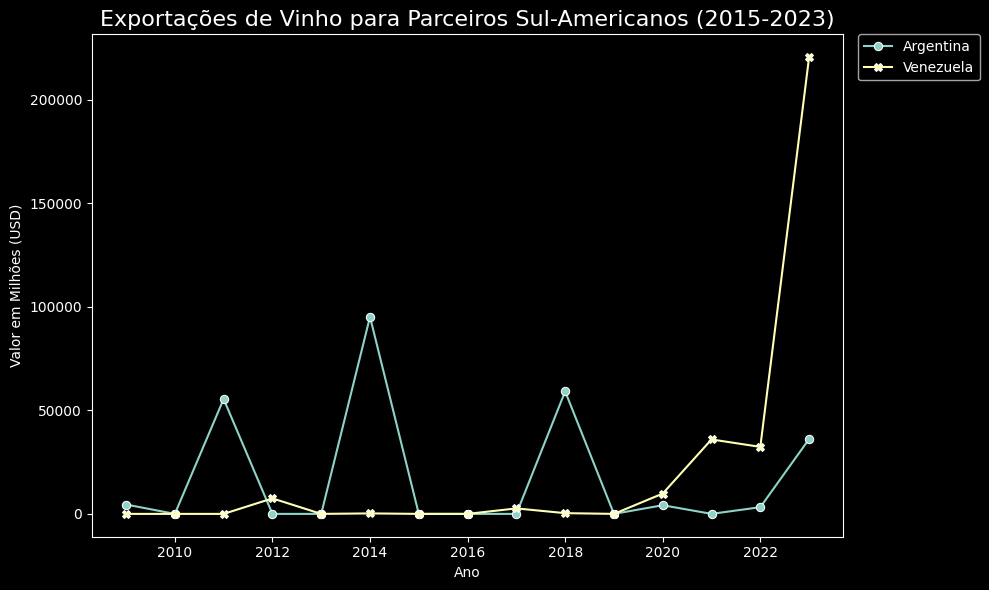

In [9]:
# Filtrando dados para Argentina e Venezuela
df_arg_ven = df_final[df_final['Pais'].isin(['Argentina', 'Venezuela'])]

plt.style.use('dark_background')
plt.figure(figsize=(10, 6))

ax = sns.lineplot(
    data=df_arg_ven,
    x='Ano',
    y='Valor_USD',
    hue='Pais',
    style='Pais',
    markers=True,
    dashes=False
)

ax.set_title('Exportações de Vinho para Parceiros Sul-Americanos (2015-2023)', fontsize=16)
ax.set_xlabel('Ano')
ax.set_ylabel('Valor em Milhões (USD)')

ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)

plt.tight_layout()
plt.show()

## 4. Análise de Impacto: Pré e Pós-COVID-19

Para quantificar o impacto da pandemia, vamos comparar a média de valor exportado nos 5 anos anteriores (2015-2019) com os 4 anos seguintes (2020-2023) para os principais parceiros.

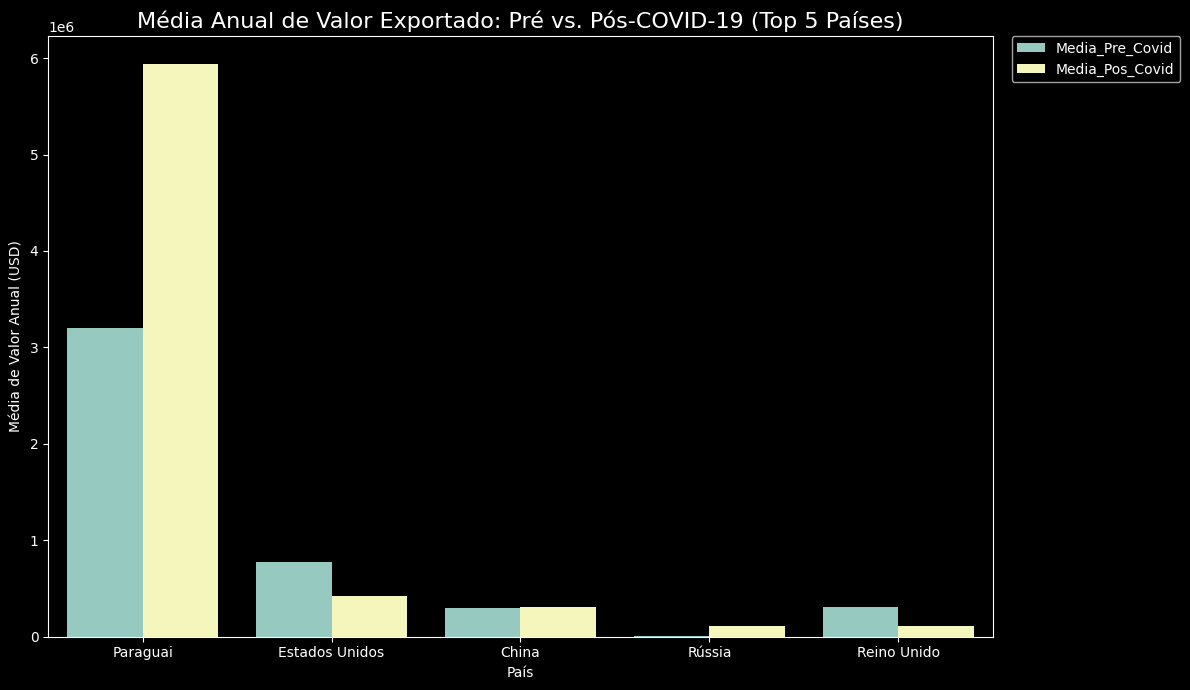

In [10]:
pre_covid = df_final[(df_final['Ano'] >= 2015) & (df_final['Ano'] <= 2019)]
pos_covid = df_final[(df_final['Ano'] >= 2020) & (df_final['Ano'] <= 2023)]

media_pre_covid = pre_covid.groupby('Pais')['Valor_USD'].mean().reset_index().rename(columns={'Valor_USD': 'Media_Pre_Covid'})
media_pos_covid = pos_covid.groupby('Pais')['Valor_USD'].mean().reset_index().rename(columns={'Valor_USD': 'Media_Pos_Covid'})

df_comparativo = pd.merge(media_pre_covid, media_pos_covid, on='Pais')
df_comparativo_top_5 = df_comparativo[df_comparativo['Pais'].isin(top_5_paises)].sort_values('Media_Pos_Covid', ascending=False)

df_comparativo_long = df_comparativo_top_5.melt(id_vars='Pais', var_name='Periodo', value_name='Media_Valor_USD')

sorted_countries = df_comparativo_top_5['Pais'].tolist()

plt.style.use('dark_background')
plt.figure(figsize=(12, 7))

ax = sns.barplot(
    data=df_comparativo_long,
    x='Pais',
    y='Media_Valor_USD',
    hue='Periodo',
    order=sorted_countries
)

ax.set_title('Média Anual de Valor Exportado: Pré vs. Pós-COVID-19 (Top 5 Países)', fontsize=16)
ax.set_xlabel('País')
ax.set_ylabel('Média de Valor Anual (USD)')

ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)

plt.tight_layout()
plt.show()

**Análise de Impacto:**
O gráfico de barras agrupado ilustra claramente o impacto da pandemia nos principais mercados.
- **Paraguai:** Mostra um aumento substancial na média de valor importado no período pós-COVID.
- **Haiti:** Confirma sua ascensão espetacular, com um crescimento exponencial da média de importações.
- **Estados Unidos e China:** Apresentam uma leve queda ou estabilidade, indicando que a pandemia não impulsionou as exportações para esses mercados da mesma forma que para os vizinhos regionais.
- **Reino Unido:** Demonstra uma queda mais acentuada na média de valor importado.

## 5. Conclusão

A análise dos dados de exportação de vinhos brasileiros de 2009 a 2023 revela uma indústria dinâmica e em transformação.

1.  **Paraguai como Pilar:** O Paraguai se consolidou como o parceiro comercial mais importante e estável para os vinhos brasileiros, com um crescimento contínuo, especialmente intensificado após 2020.

2.  **O Fenômeno do Haiti:** O mercado haitiano emergiu como um destino de exportação surpreendentemente robusto no período pós-pandemia, representando uma oportunidade significativa de crescimento.

3.  **Impacto da Pandemia:** A pandemia de COVID-19 parece ter reconfigurado os fluxos de exportação. Enquanto mercados tradicionais como EUA e Reino Unido mostraram estagnação ou declínio, os mercados da América Latina e Caribe, em especial Paraguai e Haiti, apresentaram um aumento expressivo na demanda. Isso pode ser atribuído a fatores como a logística facilitada, a competitividade de preços e a busca por novos fornecedores durante a crise global.

**Próximos Passos:** Uma análise mais aprofundada poderia incluir a correlação desses dados com indicadores econômicos (PIB, câmbio) de cada país e uma análise de preço por unidade (Valor/Quantidade) para entender melhor a estratégia de precificação e o mix de produtos exportados.